Este notebook serviu para treinar os modelos para descobrir o fare_amount. Para este efeito decidimos usar o XGBRegressor como modelo e mean absolute error como avaliador de performance. Treinamos também um modelo com a informação de 1, 2 e 3 meses para verficar se o aumento de dados leva a uma melhor performance. Decidimos usar o polars para fazer o preprocessamento pois teve boa performance nos teste anteriormente feitos.

In [49]:
import polars as pl
import pandas as pd
import xgboost as xgb
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data_path = "data/"

## Treinar com a informação de 1 mês

In [3]:
#Criação do dataframe fazendo a junção dos dados do número de meses respetivos

dfs = []

for filename in os.listdir(data_path)[:1]:
    filepath = os.path.join(data_path, filename)
    df = pd.read_parquet(filepath)
    if 'airport_fee' in df.columns:
        df.rename(columns={'airport_fee': 'Airport_fee'}, inplace=True)
    dfs.append(df)
    
df = pl.from_pandas(pd.concat(dfs, ignore_index=True))


In [4]:
#Criação de uma coluna com o tempo em minutos que durou a viagem

duration = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()/60
df = df.with_columns(duration.alias("tpep_duration"))

In [5]:
#Verificação da exe«istência de linhas com valores nulos

for column in df.columns:
    if column != 'tpep_dropoff_datetime' and column != 'tpep_dropoff_datetime':
        nans = df[column].is_null()
        if len(nans.filter(nans)) > 0:
            print(column, len(nans.filter(nans)))
    

passenger_count 99887
RatecodeID 99887
store_and_fwd_flag 99887
congestion_surcharge 99887
Airport_fee 99887


In [6]:
#Eliminação das linhas com valores nulos

df = df.drop_nulls()

In [7]:
df['store_and_fwd_flag'].unique()

store_and_fwd_flag
str
"""Y"""
"""N"""


In [8]:
#Mapeamento dos valores da coluna "store_and_fwd_flag" para valores binários

df = df.with_columns(
    pl.when(pl.col('store_and_fwd_flag') == 'Y')
    .then(1)
    .otherwise(0)
    .alias('store_and_fwd_flag')
)


In [9]:
#Criação de uma lista com o nome das colunas a ser usadas para a inferência

columns = df.columns
x_cols = [column for column in columns if column != 'tpep_dropoff_datetime' and column != 'tpep_pickup_datetime' and column != 'VendorID' and column != 'fare_amount' and column != "total_amount"]
x_cols

['passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'congestion_surcharge',
 'Airport_fee',
 'tpep_duration']

In [10]:
#Criação de uma lista com a coluna que queremos prever

y_col = ["fare_amount"]

In [11]:
#Criação do dataframe com as colunas para a inferência

X = df[x_cols]
X.head()

passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,tpep_duration
f64,f64,f64,i32,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,3.4,1.0,0,140,238,1,3.5,0.5,6.7,0.0,1.0,2.5,0.0,20.883333
0.0,3.4,1.0,0,50,151,1,3.5,0.5,3.0,0.0,1.0,2.5,0.0,10.233333
1.0,10.2,1.0,0,138,97,1,7.75,0.5,10.0,0.0,1.0,0.0,1.75,18.716667
3.0,9.83,1.0,0,100,244,1,1.0,0.5,8.88,0.0,1.0,2.5,0.0,23.433333
1.0,1.17,1.0,0,137,234,1,1.0,0.5,0.72,0.0,1.0,2.5,0.0,8.566667


In [12]:
#Criação do dataframe com a coluna que queremos prever

y = df[y_col]
y

fare_amount
f64
21.9
15.6
40.8
39.4
9.3
…
12.8
12.8
17.7


In [13]:
#Criação dos dataframes de treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [14]:
X_train.shape, X_train.shape

((2245142, 15), (2245142, 15))

In [15]:
#Treino do modelo 

one_month_model = xgb.XGBRegressor()
one_month_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
#Obtenção das previsões

one_month_preds = one_month_model.predict(X_test)

In [17]:
#Cálculo do mean absolute error

from sklearn.metrics import mean_absolute_error
one_month_mae = mean_absolute_error(y_test, one_month_preds)
print(one_month_mae)

1.7380372830880502


## Treinar com a informação de 2 meses

In [18]:
dfs = []

for filename in os.listdir(data_path)[:2]:
    filepath = os.path.join(data_path, filename)
    df = pd.read_parquet(filepath)
    if 'airport_fee' in df.columns:
        # Rename the column to "Airport_fee"
        df.rename(columns={'airport_fee': 'Airport_fee'}, inplace=True)
    dfs.append(df)
    
df = pl.from_pandas(pd.concat(dfs, ignore_index=True))


In [19]:
duration = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()/60
df = df.with_columns(duration.alias("tpep_duration"))

In [20]:
for column in df.columns:
    if column != 'tpep_dropoff_datetime' and column != 'tpep_dropoff_datetime':
        nans = df[column].is_null()
        if len(nans.filter(nans)) > 0:
            print(column, len(nans.filter(nans)))
    

passenger_count 187506
RatecodeID 187506
store_and_fwd_flag 187506
congestion_surcharge 187506
Airport_fee 187506


In [21]:
df = df.drop_nulls()

In [22]:
df['store_and_fwd_flag'].unique()

store_and_fwd_flag
str
"""Y"""
"""N"""


In [23]:
df = df.with_columns(
    pl.when(pl.col('store_and_fwd_flag') == 'Y')
    .then(1)
    .otherwise(0)
    .alias('store_and_fwd_flag')
)


In [24]:
columns = df.columns
x_cols = [column for column in columns if column != 'tpep_dropoff_datetime' and column != 'tpep_pickup_datetime' and column != 'VendorID' and column != 'fare_amount' and column != "total_amount"]
x_cols

['passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'congestion_surcharge',
 'Airport_fee',
 'tpep_duration']

In [25]:
y_col = ["fare_amount"]

In [26]:
X = df[x_cols]
X.head()

passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,tpep_duration
f64,f64,f64,i32,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,3.4,1.0,0,140,238,1,3.5,0.5,6.7,0.0,1.0,2.5,0.0,20.883333
0.0,3.4,1.0,0,50,151,1,3.5,0.5,3.0,0.0,1.0,2.5,0.0,10.233333
1.0,10.2,1.0,0,138,97,1,7.75,0.5,10.0,0.0,1.0,0.0,1.75,18.716667
3.0,9.83,1.0,0,100,244,1,1.0,0.5,8.88,0.0,1.0,2.5,0.0,23.433333
1.0,1.17,1.0,0,137,234,1,1.0,0.5,0.72,0.0,1.0,2.5,0.0,8.566667


In [27]:
y = df[y_col]
y

fare_amount
f64
21.9
15.6
40.8
39.4
9.3
…
11.4
5.1
15.6


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [29]:
X_train.shape, X_train.shape

((4566445, 15), (4566445, 15))

In [30]:
two_month_model = xgb.XGBRegressor()
two_month_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
two_month_preds = two_month_model.predict(X_test)

In [32]:
from sklearn.metrics import mean_absolute_error
two_month_mae = mean_absolute_error(y_test, two_month_preds)
print(two_month_mae)

1.4867250957487046


## Treinar com a informação de 3 meses

In [33]:
dfs = []

for filename in os.listdir(data_path)[:3]:
    filepath = os.path.join(data_path, filename)
    df = pd.read_parquet(filepath)
    if 'airport_fee' in df.columns:
        df.rename(columns={'airport_fee': 'Airport_fee'}, inplace=True)
    dfs.append(df)
    
df = pl.from_pandas(pd.concat(dfs, ignore_index=True))


In [34]:
duration = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()/60
df = df.with_columns(duration.alias("tpep_duration"))

In [35]:
for column in df.columns:
    if column != 'tpep_dropoff_datetime' and column != 'tpep_dropoff_datetime':
        nans = df[column].is_null()
        if len(nans.filter(nans)) > 0:
            print(column, len(nans.filter(nans)))
    

passenger_count 278196
RatecodeID 278196
store_and_fwd_flag 278196
congestion_surcharge 278196
Airport_fee 278196


In [36]:
df = df.drop_nulls()

In [37]:
df['store_and_fwd_flag'].unique()

store_and_fwd_flag
str
"""Y"""
"""N"""


In [38]:
df = df.with_columns(
    pl.when(pl.col('store_and_fwd_flag') == 'Y')
    .then(1)
    .otherwise(0)
    .alias('store_and_fwd_flag')
)


In [39]:
columns = df.columns
x_cols = [column for column in columns if column != 'tpep_dropoff_datetime' and column != 'tpep_pickup_datetime' and column != 'VendorID' and column != 'fare_amount' and column != "total_amount"]
x_cols

['passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'congestion_surcharge',
 'Airport_fee',
 'tpep_duration']

In [40]:
y_col = ["fare_amount"]

In [41]:
X = df[x_cols]
X.head()

passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,tpep_duration
f64,f64,f64,i32,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,3.4,1.0,0,140,238,1,3.5,0.5,6.7,0.0,1.0,2.5,0.0,20.883333
0.0,3.4,1.0,0,50,151,1,3.5,0.5,3.0,0.0,1.0,2.5,0.0,10.233333
1.0,10.2,1.0,0,138,97,1,7.75,0.5,10.0,0.0,1.0,0.0,1.75,18.716667
3.0,9.83,1.0,0,100,244,1,1.0,0.5,8.88,0.0,1.0,2.5,0.0,23.433333
1.0,1.17,1.0,0,137,234,1,1.0,0.5,0.72,0.0,1.0,2.5,0.0,8.566667


In [42]:
y = df[y_col]
y

fare_amount
f64
21.9
15.6
40.8
39.4
9.3
…
40.8
8.6
7.9


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [44]:
X_train.shape, X_train.shape

((6804737, 15), (6804737, 15))

In [45]:
three_month_model = xgb.XGBRegressor()
three_month_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [46]:
three_month_preds = three_month_model.predict(X_test)

In [47]:
from sklearn.metrics import mean_absolute_error
three_month_mae = mean_absolute_error(y_test, three_month_preds)
print(three_month_mae)

1.1983540258503862


## Análise

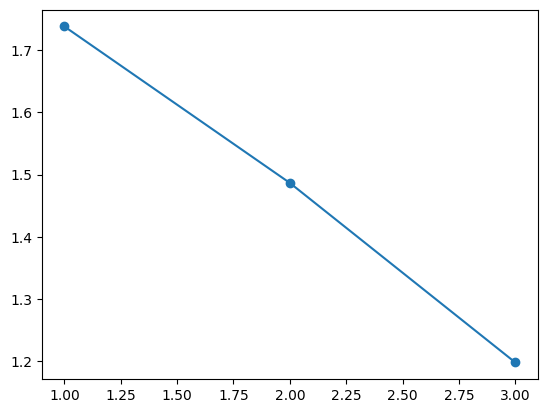

In [52]:
y = [1, 2, 3]
scores = [one_month_mae,two_month_mae,three_month_mae]
#plt.plot([one_month_mae,two_month_mae,three_month_mae])
plt.scatter(y, scores)
plt.plot(y, scores)

Como se pode ver no gráfico, à medida que se vai aumentando o número de dados de treino, o mean absolute error (mae) vai diminuindo. Com os dados de 3 meses, obtivemos um mae de 1.1983540258503862 